In [33]:
%load_ext autoreload
import ais_predict.trajpred.posgp as pgp
import ais_predict.datasets.bigquery as bq
import matplotlib.pyplot as plt
from ais_predict.visualization import plotting
import geopandas as gpd
import seaborn as sns
import random
import numpy as np
sns.set()
latex_width = 369.88583
plt.rcParams["figure.figsize"] = plotting.set_size(latex_width)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "text.latex.preamble": r'\usepackage{amsfonts}'
}

plt.rcParams.update(tex_fonts)

<AxesSubplot:>

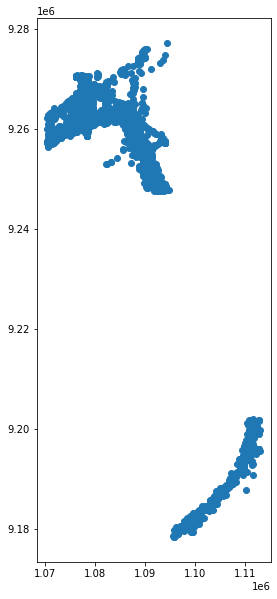

In [2]:
df = bq.download(limit=10000, lead=10, shuffle=True)
df.position.plot()

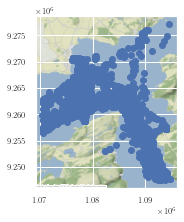

In [53]:
%autoreload
import contextily as ctx
ix = df.position.y > 9.24e6
ax = df[ix].plot()
ctx.add_basemap(ax, attribution_size=2)


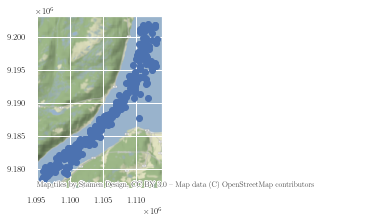

In [40]:
ax = df[~ix].plot()
ctx.add_basemap(ax)

<AxesSubplot:>

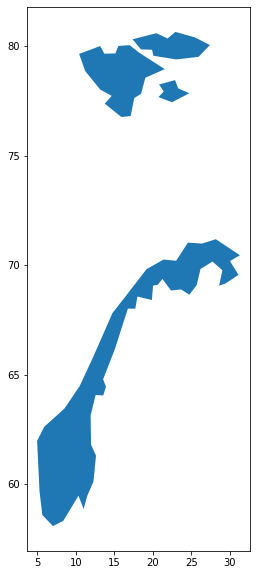

In [11]:
world[world.name=="Norway"].plot()

<AxesSubplot:>

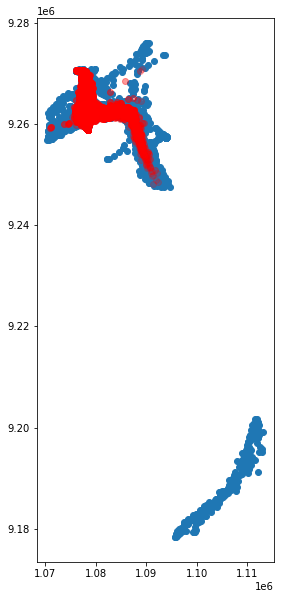

In [3]:
center = df.position.sample().to_crs(epsg=3857).to_numpy()[0]
subset = df.to_crs(epsg=3857).within(center.buffer(2e3))
ax = df.plot()
df[subset].plot(ax=ax, color="red")
df[subset].position_1.plot(ax=ax, color="red", alpha=0.9)
df[subset].position_2.plot(ax=ax, color="red", alpha=0.8)
df[subset].position_3.plot(ax=ax, color="red", alpha=0.7)
df[subset].position_4.plot(ax=ax, color="red", alpha=0.6)
df[subset].position_5.plot(ax=ax, color="red", alpha=0.5)
df[subset].position_6.plot(ax=ax, color="red", alpha=0.4)
df[subset].position_7.plot(ax=ax, color="red", alpha=0.3)
df[subset].position_8.plot(ax=ax, color="red", alpha=0.2)


In [6]:
%autoreload
within = gpd.GeoSeries(center.buffer(2e3), crs="epsg:3857").to_crs("wgs84").to_numpy()[0]
d = bq.download(lead=8, within=within, limit=10000, min_knots=5)

In [43]:
minutes = ((df.timestamp_10 - df.timestamp).dt.seconds / 60)
msk = (minutes < 25) & (minutes > 15)
msk = msk & (df.sog > 3)   

d = df.loc[msk]

cog_sum = abs(d.cog_1 - d.cog)
cog_cols = d.columns.str.contains("cog")
for i in range(1, 10):
    diff = abs(d[f"cog_{i+1}"] - d[f"cog_{i}"])
    cog_sum += diff
d = d.loc[cog_sum > 40].copy()


d["date"] = d.timestamp.dt.date
date_grouping = d.groupby("date")
groups = list(date_grouping.groups.keys())
random.shuffle(groups)
test_date = groups[1::3]

test_df = d.loc[d.date.isin(test_date)]
train_df = df.loc[~df.index.isin(test_df.index)]

/home/haavard/.pyenv/versions/master-thesis/lib/python3.9/site-packages/pandas/core/strings/accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


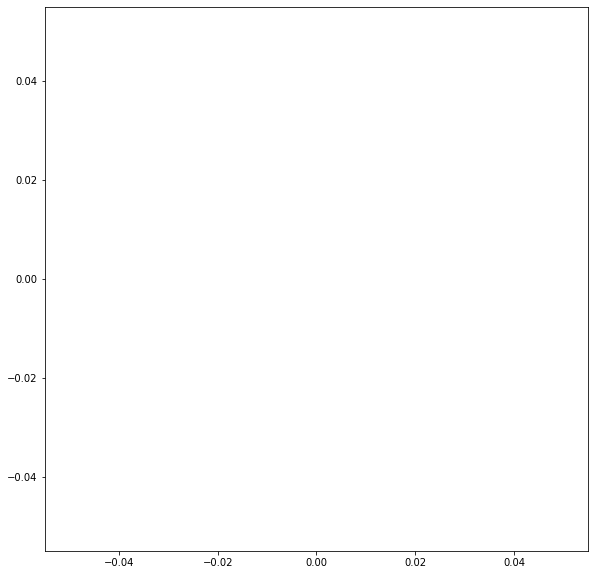

In [8]:
from shapely.geometry import Point, LineString
import geopandas as gpd
cols = d.columns.str.contains('position(_.*)?')
p = gpd.GeoSeries(d.loc[:, cols].apply(lambda x: LineString(x.tolist()), axis=1), crs="wgs84").to_crs(epsg=3857)
temp = gpd.GeoDataFrame({"lines": p, "cog": d.cog}, geometry="lines")
#print(d.loc[:, cols].dtypes)
ax = gpd.GeoSeries(d.loc[:, cols].melt().value, crs="wgs84").to_crs(epsg=3857).plot(color="red")
ax = temp.plot(ax=ax, alpha=0.3)

In [9]:
t = d.loc[(d.timestamp_1 - d.timestamp).dt.seconds < 10*60, :]
train_msk = np.random.rand(len(t)) < 0.5 
train = t[train_msk]
test = t[~train_msk]
train_x, train_y = pgp.samples_from_lag_n_df(train, n=10)
test_x, test_y = pgp.samples_from_lag_n_df(test, n=10)
msk = (test_x[:, -1] < 30*60)
test_x = test_x[msk, :]
test_y = test_y[msk, :]

/home/haavard/.pyenv/versions/master-thesis/lib/python3.9/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


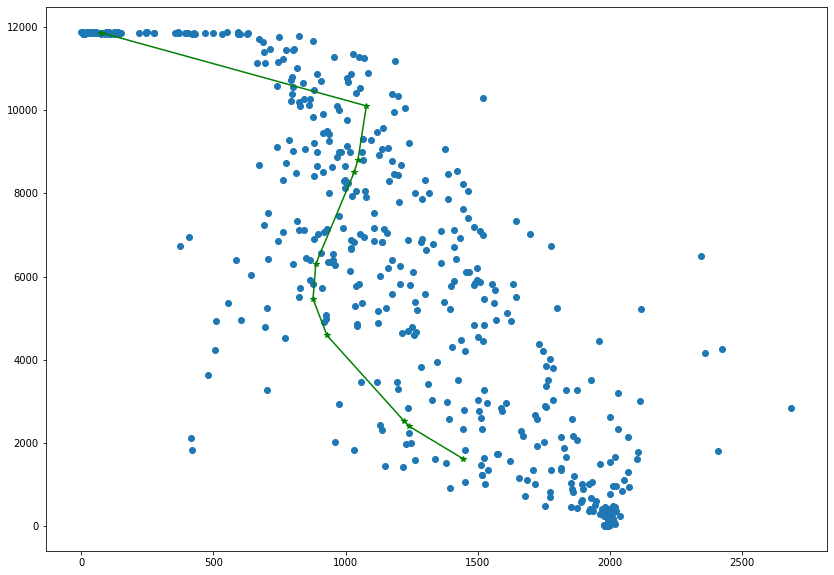

In [53]:
%autoreload
import ais_predict.trajpred.dyngp as dyngp
from ais_predict.visualization import plotting
import numpy as np
init = test_df.sample(1)
train_df["init_dist"] = abs(train_df.position.distance(init.position.to_numpy()[0]))
train_df["cog_dist"] = abs(train_df.cog.to_numpy() - init.cog.to_numpy())
train_df["sog_dist"] = abs(train_df.sog.to_numpy() - init.sog.to_numpy())

train_df_dir = train_df.loc[train_df["cog_dist"] < 20]
train_df_dir = train_df_dir.loc[train_df_dir["sog_dist"] < 2]
train_df_dir = train_df_dir.loc[train_df_dir["init_dist"] < 1000]
train_df_dir = train_df_dir.sort_values(by="init_dist")
train_x, train_y = pgp.samples_from_lag_n_df(train_df_dir, 10)

# Remove any non-moving samples
msk = np.linalg.norm(train_y, axis=1) > 3
train_x, train_y = train_x[msk], train_y[msk]


# Pick first (assumed best) 500 samples - reduce computation time
train_x = train_x[:500]
train_y = train_y[:500]

y_min = train_y[:, :2].min(axis=0)
train_x[:, :2] -= y_min
train_y[:, :2] -= y_min



xlim, ylim = plotting.limits(train_y[:, :2])
init_x, init_y = pgp.samples_from_lag_n_df(init, 10)
init_x[:, :2] -= y_min
init_y[:, :2] -= y_min
plt.scatter(*train_y.T[:2])
plt.plot(*(init_y[:, :2]).T, "*-", color="green")

1.23**2 * RBF(length_scale=[203, 10.6, 13.7, 0.527, 356]) + WhiteKernel(noise_level=0.00559)
[120.78072011 180.3493152    0.        ]


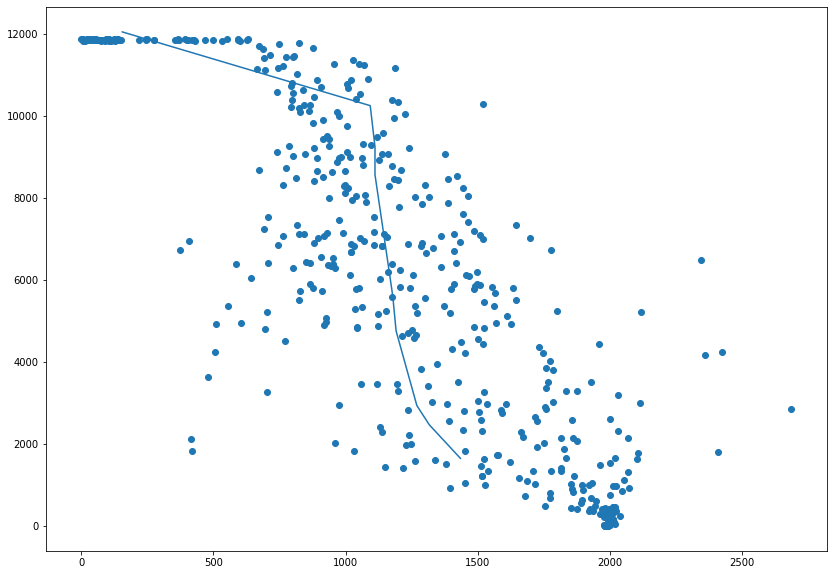

In [55]:
%autoreload
m = pgp.PosGP(train_x, train_y)
print(m.gp.kernel_)
f, P = m(init_x)
print(np.mean(abs(f - init_y), axis=0))
plt.plot(*f.T[:2])
plt.scatter(*train_y.T[:2])

x = init_x[0][np.newaxis,...].repeat(100, axis=0)
x[:, -1] = np.linspace(0, init_x[-1, -1], 100)
x = np.append(x, init_x, axis=0)
six = np.argsort(x[:, -1])
x = x[six]
f, P = m(x)

In [59]:
plt.plot(*f.T[:2], color="red")
plt.scatter(*train_y.T[:2])
plt.scatter(*init_y.T[:2], color="yellow")
subset, _ = metrics.compare_trajectories(f, init_y)
plotting.confidence_ellipse(*f.T[:2, subset], P[subset], plt.gca(), edgecolor="red")

IndexError: arrays used as indices must be of integer (or boolean) type

In [16]:
from ais_predict.utilities import metrics
metrics.nees(f, P, init_y)

array([1.69610595e-04, 7.68360020e-01, 8.15362135e-01, 7.90291917e-01,
       8.13712245e-01, 7.98878063e-01, 1.87327080e+00, 1.85199832e+00,
       1.98688589e+00, 2.02886595e+00])